Mean Squared Error: 63.7679


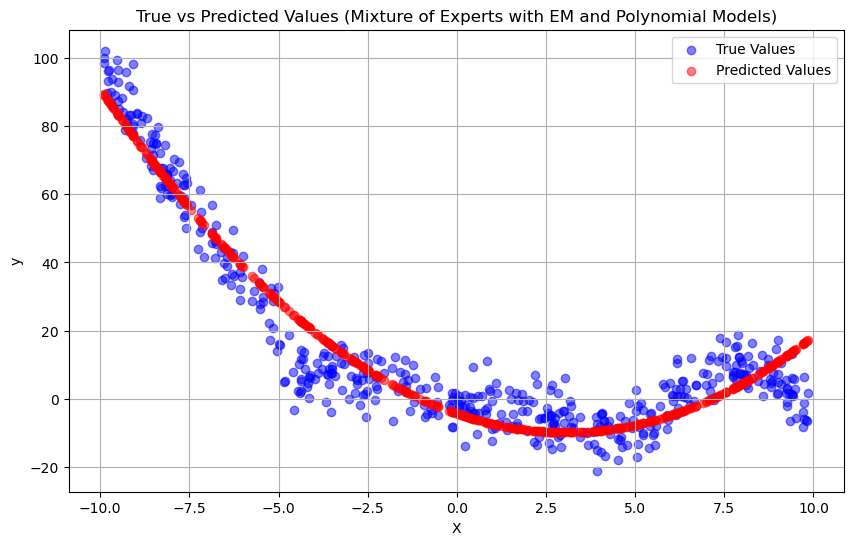

In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import t, norm

class MixtureOfExpertsEM:
    def __init__(self, n_experts, degree=2, max_iter=100, tol=1e-6, nu=3):
        self.n_experts = n_experts
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.poly_transformers = [PolynomialFeatures(degree=self.degree) for _ in range(n_experts)]
        self.experts = [LinearRegression() for _ in range(n_experts)]
        self.alpha = np.ones(n_experts) / n_experts  # Initial proportions

    def _compute_responsibilities(self, X, y):
        responsibilities = np.zeros((X.shape[0], self.n_experts))
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions = expert.predict(X_poly)
            responsibilities[:, j] = self.alpha[j] * norm.pdf(y, loc=predictions, scale=self.sigma[j])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _update_parameters(self, X, y, responsibilities):
        N_k = responsibilities.sum(axis=0)  # Effective number of samples per expert
        self.alpha = N_k / X.shape[0]  # Update proportions

        for j, expert in enumerate(self.experts):
            weights = responsibilities[:, j]
            X_poly = self.poly_transformers[j].fit_transform(X)
            expert.fit(X_poly, y, sample_weight=weights)

            # Update variance (sigma^2)
            predictions = expert.predict(X_poly)
            residuals = (y - predictions) ** 2
            self.sigma[j] = np.sqrt(np.average(residuals, weights=weights))

    def fit(self, X, y):
        # Initialize experts and variances
        self.sigma = np.std(y) * np.ones(self.n_experts)  # Initial variances
        responsibilities = np.ones((X.shape[0], self.n_experts)) / self.n_experts

        # Pre-train experts using all data equally
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].fit_transform(X)
            expert.fit(X_poly, y)

        log_likelihood = -np.inf
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._compute_responsibilities(X, y)

            # M-step: Update parameters
            self._update_parameters(X, y, responsibilities)

            # Compute log-likelihood
            new_log_likelihood = np.sum(np.log(np.sum(
                [self.alpha[j] * norm.pdf(y, loc=self.experts[j].predict(self.poly_transformers[j].transform(X)), scale=self.sigma[j])
                 for j in range(self.n_experts)], axis=0)))

            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break
            log_likelihood = new_log_likelihood

    def predict(self, X):
        # Compute responsibilities for the new data
        responsibilities = np.zeros((X.shape[0], self.n_experts))
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions = expert.predict(X_poly)
            responsibilities[:, j] = self.alpha[j] * norm.pdf(predictions, loc=predictions, scale=self.sigma[j])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # Compute weighted predictions
        predictions = np.zeros(X.shape[0])
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions += responsibilities[:, j] * expert.predict(X_poly)
        return predictions

# Generate synthetic data for testing
import matplotlib.pyplot as plt

# Create a more complex dataset with nonlinear patterns
np.random.seed(42)
X = np.random.uniform(-10, 10, size=(500, 1))
y = np.piecewise(X.flatten(), 
                 [X.flatten() < -5, (X.flatten() >= -5) & (X.flatten() <= 5), X.flatten() > 5],
                 [lambda x: x**2 + np.random.normal(0, 5, len(x)),
                  lambda x: -2*x + np.random.normal(0, 5, len(x)),
                  lambda x: np.sin(x) * 10 + np.random.normal(0, 5, len(x))])

# Train Mixture of Experts model using EM
moe_em = MixtureOfExpertsEM(n_experts=3, degree=2)
moe_em.fit(X, y)

# Make predictions
predictions = moe_em.predict(X)

# Evaluate model performance
mse = np.mean((predictions - y) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot true vs predicted values for visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='True Values', color='blue')
plt.scatter(X, predictions, alpha=0.5, label='Predicted Values', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('True vs Predicted Values (Mixture of Experts with EM and Polynomial Models)')
plt.legend()
plt.grid(True)
plt.show()



Mean Squared Error: 63.7679


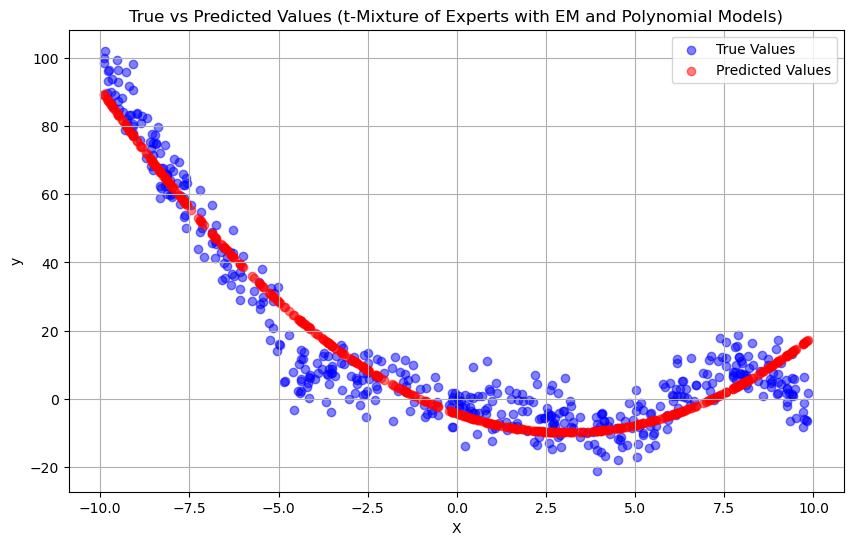

In [2]:
class tMixtureOfExpertsEM:
    def __init__(self, n_experts, degree=2, max_iter=100, tol=1e-6, nu=3):
        self.n_experts = n_experts
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.nu = nu  # Degrees of freedom for Student's t-distribution
        self.poly_transformers = [PolynomialFeatures(degree=self.degree) for _ in range(n_experts)]
        self.experts = [LinearRegression() for _ in range(n_experts)]
        self.alpha = np.ones(n_experts) / n_experts  # Initial proportions

    def _compute_responsibilities(self, X, y):
        responsibilities = np.zeros((X.shape[0], self.n_experts))
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions = expert.predict(X_poly)
            scale = self.sigma[j] * np.sqrt((self.nu + 1) / self.nu)  # Scale for t-distribution
            responsibilities[:, j] = self.alpha[j] * t.pdf((y - predictions) / scale, df=self.nu)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _update_parameters(self, X, y, responsibilities):
        N_k = responsibilities.sum(axis=0)  # Effective number of samples per expert
        self.alpha = N_k / X.shape[0]  # Update proportions

        for j, expert in enumerate(self.experts):
            weights = responsibilities[:, j]
            X_poly = self.poly_transformers[j].fit_transform(X)
            expert.fit(X_poly, y, sample_weight=weights)

            # Update scale (sigma) using weighted residuals
            predictions = expert.predict(X_poly)
            residuals = (y - predictions) ** 2
            weighted_residuals = weights * residuals
            self.sigma[j] = np.sqrt(np.sum(weighted_residuals) / (N_k[j] * (self.nu / (self.nu - 2))))

    def fit(self, X, y):
        # Initialize experts and scales
        self.sigma = np.std(y) * np.ones(self.n_experts)  # Initial scales
        responsibilities = np.ones((X.shape[0], self.n_experts)) / self.n_experts

        # Pre-train experts using all data equally
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].fit_transform(X)
            expert.fit(X_poly, y)

        log_likelihood = -np.inf
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            responsibilities = self._compute_responsibilities(X, y)

            # M-step: Update parameters
            self._update_parameters(X, y, responsibilities)

            # Compute log-likelihood
            new_log_likelihood = np.sum(np.log(np.sum(
                [self.alpha[j] * t.pdf((y - self.experts[j].predict(self.poly_transformers[j].transform(X))) / self.sigma[j], df=self.nu)
                 for j in range(self.n_experts)], axis=0)))

            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                break
            log_likelihood = new_log_likelihood

    def predict(self, X):
        # Compute responsibilities for the new data
        responsibilities = np.zeros((X.shape[0], self.n_experts))
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions = expert.predict(X_poly)
            responsibilities[:, j] = self.alpha[j] * t.pdf((y - predictions) / self.sigma[j], df=self.nu)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # Compute weighted predictions
        predictions = np.zeros(X.shape[0])
        for j, expert in enumerate(self.experts):
            X_poly = self.poly_transformers[j].transform(X)
            predictions += responsibilities[:, j] * expert.predict(X_poly)
        return predictions
    

# Create a more complex dataset with nonlinear patterns
np.random.seed(42)
X = np.random.uniform(-10, 10, size=(500, 1))
y = np.piecewise(X.flatten(), 
                 [X.flatten() < -5, (X.flatten() >= -5) & (X.flatten() <= 5), X.flatten() > 5],
                 [lambda x: x**2 + np.random.normal(0, 5, len(x)),
                  lambda x: -2*x + np.random.normal(0, 5, len(x)),
                  lambda x: np.sin(x) * 10 + np.random.normal(0, 5, len(x))])

# Train t-Mixture of Experts model using EM
tmoe_em = tMixtureOfExpertsEM(n_experts=3, degree=2, nu=3)
tmoe_em.fit(X, y)

# Make predictions
predictions = tmoe_em.predict(X)

# Evaluate model performance
mse = np.mean((predictions - y) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot true vs predicted values for visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='True Values', color='blue')
plt.scatter(X, predictions, alpha=0.5, label='Predicted Values', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('True vs Predicted Values (t-Mixture of Experts with EM and Polynomial Models)')
plt.legend()
plt.grid(True)
plt.show()


MoE Mean Squared Error: 2527.2569
tMoE Mean Squared Error: 2527.2569


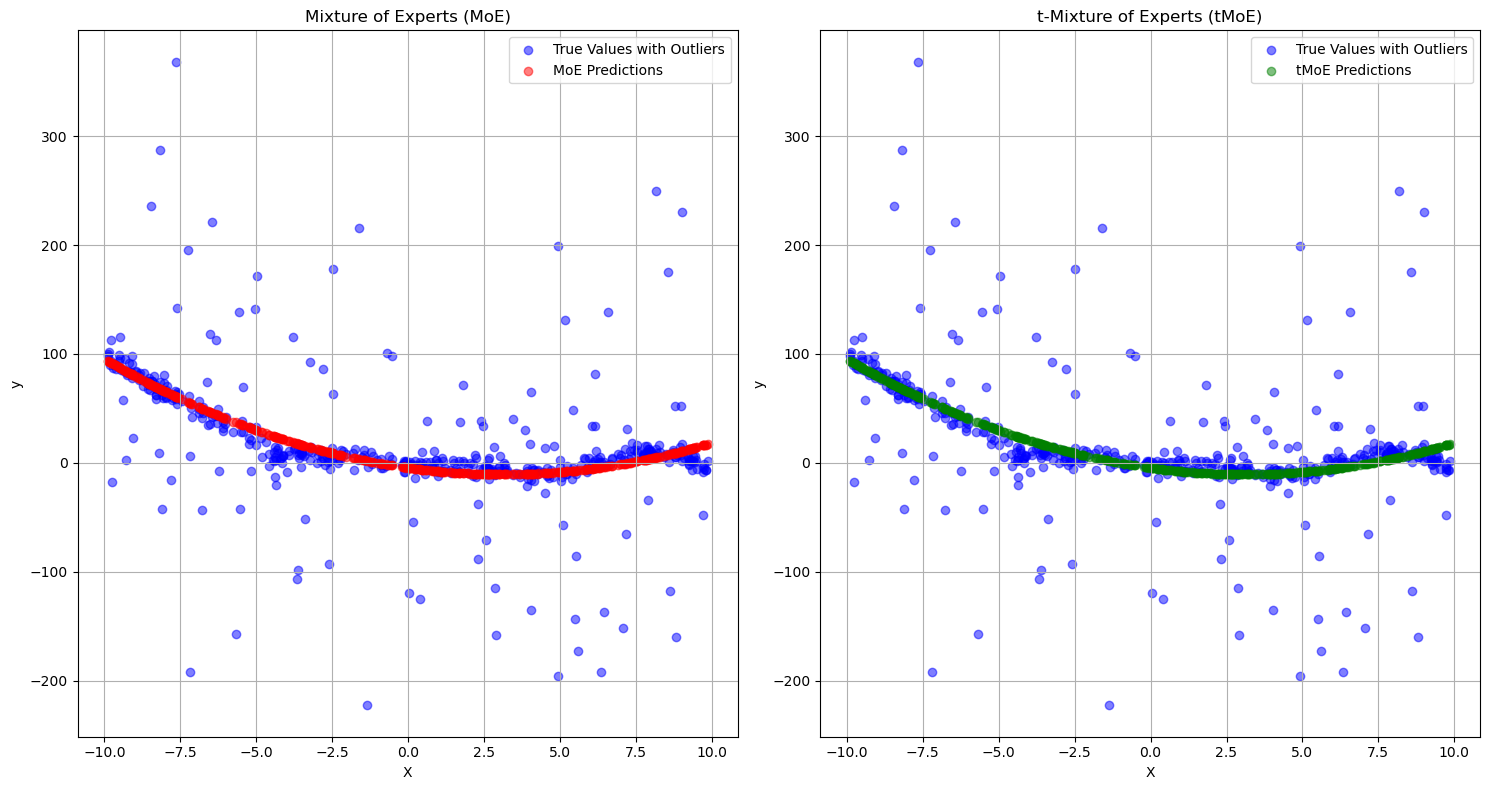

In [4]:
# Generate synthetic data with heavy-tailed outliers
np.random.seed(42)
X = np.random.uniform(-10, 10, size=(500, 1))
y = np.piecewise(X.flatten(), 
                 [X.flatten() < -5, (X.flatten() >= -5) & (X.flatten() <= 5), X.flatten() > 5],
                 [lambda x: x**2 + np.random.normal(0, 5, len(x)),
                  lambda x: -2*x + np.random.normal(0, 5, len(x)),
                  lambda x: np.sin(x) * 10 + np.random.normal(0, 5, len(x))])

# Add heavy-tailed outliers
y[np.random.choice(len(y), size=100, replace=False)] += np.random.normal(0, 100, size=100)

# Train MoE and tMoE models
moe_em = MixtureOfExpertsEM(n_experts=3, degree=2)
tmoe_em = tMixtureOfExpertsEM(n_experts=3, degree=2, nu=3)

moe_em.fit(X, y)
tmoe_em.fit(X, y)

# Predict
moe_predictions = moe_em.predict(X)
tmoe_predictions = tmoe_em.predict(X)

# Compute MSE
moe_mse = np.mean((moe_predictions - y) ** 2)
tmoe_mse = np.mean((tmoe_predictions - y) ** 2)

print(f"MoE Mean Squared Error: {moe_mse:.4f}")
print(f"tMoE Mean Squared Error: {tmoe_mse:.4f}")

# Plot results
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.5, label='True Values with Outliers', color='blue')
plt.scatter(X, moe_predictions, alpha=0.5, label='MoE Predictions', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Mixture of Experts (MoE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X, y, alpha=0.5, label='True Values with Outliers', color='blue')
plt.scatter(X, tmoe_predictions, alpha=0.5, label='tMoE Predictions', color='green')
plt.xlabel('X')
plt.ylabel('y')
plt.title('t-Mixture of Experts (tMoE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()